In [ ]:
import warnings
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

from feature_descriptors.feature_descriptors import HogFeatureDescriptor

%matplotlib inline

## Helper functions

In [5]:
def predict_class(img, feature_descriptor, model, class_map):
    """
    Executes inference pipeline
    :param img:
    :param feature_descriptor:
    :param model:
    :param class_map:
    :return:
    """
    features = feature_descriptor.predict(img)[np.newaxis, ...].astype(np.float32)
    pred = model.predict(features)[1][0][0]

    return class_map[pred]

## Constants

In [6]:
DEVICE = 'cuda:0'
YOLOV5_WEIGHTS_PATH = '/home/rizvan/f22/intro-to-cv/project/cars-tracking/yolov5/runs/train/yolov5m/weights/best.pt'
SVM_WEIGHTS_PATH = '/home/rizvan/f22/intro-to-cv/project/cars-tracking/feature_descriptors/svm.dat'
CLASS_MAP_PATH = '/home/rizvan/f22/intro-to-cv/project/cars-tracking/feature_descriptors/class_map.json'
TEST_IMG_PATH = '/home/rizvan/f22/intro-to-cv/project/cars-tracking/data/vriv/preprocessed/frames/ford_escape_2011_blue_03/frame300.jpg'

## Initialize models

### YOLOv5 object detector

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=UserWarning)
    object_detector = torch.hub.load(
        'ultralytics/yolov5', 'custom', path=YOLOV5_WEIGHTS_PATH, force_reload=True
    )
object_detector.to(DEVICE)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/rizvan/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-11-26 Python-3.10.4 torch-1.13.0 CUDA:0 (NVIDIA A100 80GB PCIe, 81112MiB)

Fusing layers... 
Model summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 48, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  

### HOG
The calculation process of HOG contains the following steps:
1) Image normalization
2) Gradient calculation
3) Gradient orientation calculation
4) Gradient histogram calculation
5) Block normalization


The resulted feature vector is the concatenation of the normalized
histograms of each block.

In [8]:
hog = HogFeatureDescriptor()

### SVM

The SVM is based on the concept of hyperplane. The SVM finds the
hyperplane that separates the data into two classes with the
maximum margin.

In [9]:
svm = cv2.ml.SVM_load(SVM_WEIGHTS_PATH)

## Load class map

CLASS_MAP_PATH contains classes of cars in json format.

In [10]:
with open(CLASS_MAP_PATH, 'r') as f:
    class_map = json.load(f)
class_map = {int(k): v for k, v in class_map.items()}

## Inference

### Load test image

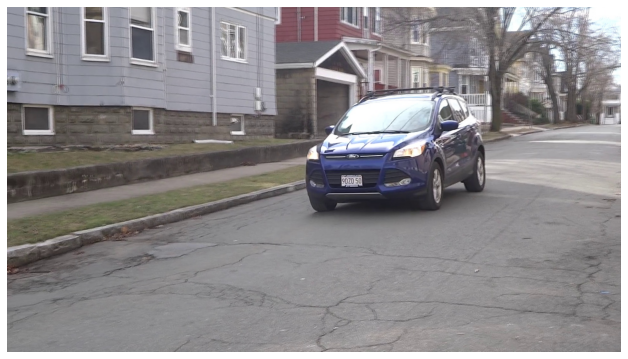

In [11]:
test_img = cv2.cvtColor(cv2.imread(TEST_IMG_PATH), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(11, 11))
plt.imshow(test_img)
plt.axis('off')
plt.show()

### Detect car(s) on image

Applying the model on the test image and get json with the coordinates of the objects.

In [12]:
detections = json.loads(object_detector(test_img).pandas().xyxy[0].to_json(orient='records'))
for det in detections:
    x_min, y_min, x_max, y_max = int(det['xmin']), int(det['ymin']), int(det['xmax']), int(det['ymax'])
    test_img = cv2.rectangle(test_img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

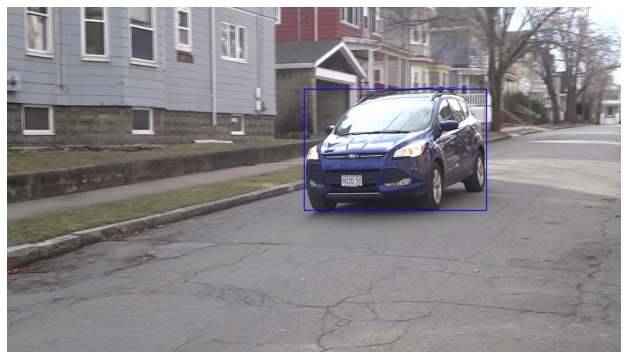

In [13]:
plt.figure(figsize=(11, 11))
plt.imshow(test_img)
plt.axis('off')
plt.show()

### Run HOG + SVM on each car's bounding box' prediction

Cropping bounding box for each prediction and applying SVM for each detected object.

In [14]:
for det in detections:
    crop = test_img[y_min: y_max, x_min: x_max]
    class_name = predict_class(crop, hog, svm, class_map)
    text_width, text_height = cv2.getTextSize(
        class_name, cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2)[0]
    y_center = (y_min + y_max) // 2
    text_origin = (x_min + 17, y_center + 17)
    box_coords = (
        (text_origin[0], text_origin[1]),
        (text_origin[0] + text_width + 2, text_origin[1] - text_height - 2)
    )
    background_color = (0, 0, 0)
    test_img = cv2.rectangle(test_img, box_coords[0], box_coords[1], background_color, cv2.FILLED)
    color = (255 - background_color[0], 255 - background_color[1], 255 - background_color[2])
    cv2.putText(
        test_img, class_name, text_origin, cv2.FONT_HERSHEY_SIMPLEX, 1, tuple(color), 2, cv2.LINE_AA
    )

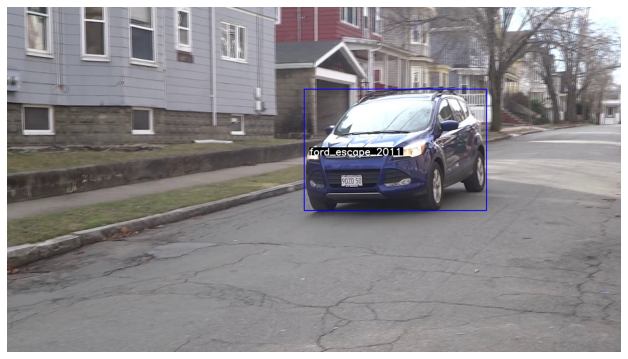

In [15]:
plt.figure(figsize=(11, 11))
plt.imshow(test_img)
plt.axis('off')
plt.show()